In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import metrics
import collection
import seaborn as sns

In [2]:
obs=pd.read_csv('../data/box_samples.csv',index_col=0)
obs.describe()

/Users/terrylines/Documents/GNSS/gnssmapper/.venv/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,x,y,w,z,a,b,d_ray,d_building,az,el
count,9.818701e+06,9.818701e+06,532792.000000,532792.000000,532792.000000,532792.000000,532792.000000,9.818701e+06,532792.000000,9.818701e+06
mean,5.280000e+05,1.829999e+05,19.225797,30.865144,527999.809649,182999.615546,35.612939,4.358095e+01,170.401776,2.927098e+01
std,3.760252e+01,3.759663e+01,11.006808,54.873598,4.157526,3.981664,21.261409,1.800211e+01,106.283867,2.220401e+01
min,5.279350e+05,1.829350e+05,0.000013,1.000002,527995.000000,182995.000000,0.000150,0.000000e+00,0.000457,2.719667e-07
25%,5.279673e+05,1.829673e+05,10.005094,5.050877,527995.000000,182995.000000,17.498588,3.073431e+01,63.631802,1.052315e+01
50%,5.280001e+05,1.829999e+05,19.285310,13.661564,527999.598747,182999.290685,35.083603,4.560400e+01,162.211845,2.420838e+01
75%,5.280326e+05,1.830325e+05,27.995479,33.269313,528004.997074,183003.921032,52.673070,5.722422e+01,278.323853,4.470096e+01
max,5.280650e+05,1.830650e+05,39.999787,982.105718,528005.000000,183005.000000,91.102705,8.476163e+01,359.999369,8.499999e+01


In [3]:
metrics.int_metric(obs.z,10,4)

116647

10 million obs give 500k that intersect, and 116k with an I_4 metric

In [4]:
bounds=[np.floor(obs.x.min()),np.floor(obs.y.min()),np.ceil(obs.x.max()-1e-3),np.ceil(obs.y.max())]

In [5]:
bounds

[527935.0, 182935.0, 528065.0, 183065.0]

In [6]:
observations_plot=collection.create_image(obs.x,obs.y,np.ones_like(obs.x),0.5,bounds,mean=False)
np.nanmean(observations_plot)/np.nanstd(observations_plot)

7.430265088676925

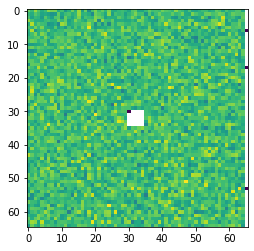

In [7]:
plt.imshow(observations_plot)

In [8]:
pd.DataFrame(observations_plot.flatten()).describe()

,0
count,4204.000000
mean,2335.561608
std,314.368250
min,35.000000
25%,2126.000000
50%,2331.000000
75%,2539.000000
max,3374.000000


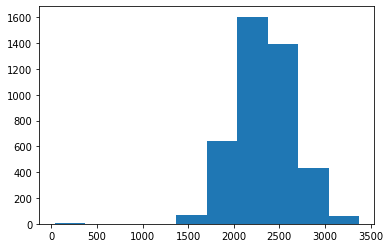

In [9]:
plt.hist(observations_plot.flatten())
plt.show()

Normally distributed number of observations in each cell

In [10]:
intersection_plot=collection.create_image(obs.x,obs.y,~obs.z.isna(),0.5,bounds,mean=True)

In [11]:
pd.DataFrame(intersection_plot.flatten()).describe()

,0
count,4204.000000
mean,0.054219
std,0.050112
min,0.000000
25%,0.028123
50%,0.040298
75%,0.061728
max,1.000000


<AxesSubplot:ylabel='Count'>

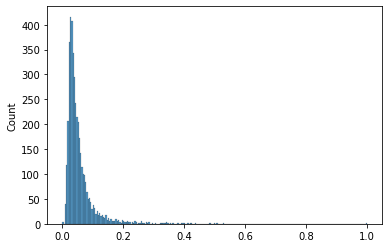

In [12]:
sns.histplot(intersection_plot.flatten())

/var/folders/kr/9rjggpcj2qx4ndk46ffx_t8w0000gn/T/ipykernel_31092/1612888096.py:1: RuntimeWarning: divide by zero encountered in log
  a=np.log(intersection_plot)


<AxesSubplot:ylabel='Count'>

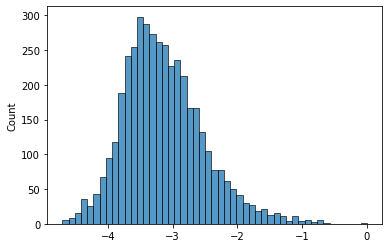

In [13]:
a=np.log(intersection_plot)
a=np.ma.masked_invalid(a)
sns.histplot(a.flatten())

lognormal distribution of intersection

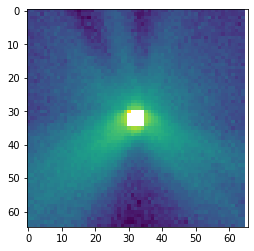

In [14]:
plt.imshow(a)

Spatial correlation of observation effectiveness. Being closer is better. Directly south is bad, but se and sw is good.

/Users/terrylines/Documents/GNSS/gnssmapper/.venv/lib/python3.9/site-packages/matplotlib/axes/_base.py:507: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


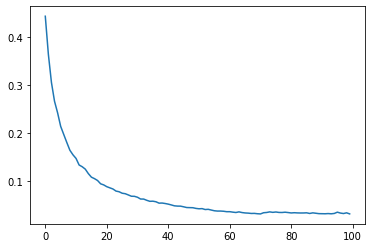

In [15]:
plt.plot((1-obs.z.isna()).groupby(pd.cut(obs.d_building,100)).mean())

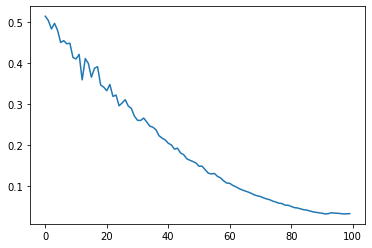

In [16]:
plt.plot((1-obs.z.isna()).groupby(pd.cut(np.log(1+obs.d_building),100)).mean())

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
obs['i']=1-obs.z.isna()
obs

,x,y,w,z,a,b,d_ray,d_building,az,el,i
0,527988.258896,182938.021189,NaN,NaN,NaN,NaN,NaN,57.376191,NaN,11.311725,0
1,527988.258896,182938.021189,NaN,NaN,NaN,NaN,NaN,57.376191,NaN,28.868598,0
2,527988.258896,182938.021189,NaN,NaN,NaN,NaN,NaN,57.376191,NaN,6.017766,0
3,527988.258896,182938.021189,NaN,NaN,NaN,NaN,NaN,57.376191,NaN,48.477686,0
4,527988.258896,182938.021189,NaN,NaN,NaN,NaN,NaN,57.376191,NaN,17.981631,0
...,...,...,...,...,...,...,...,...,...,...,...
9818696,527977.407625,182953.057888,NaN,NaN,NaN,NaN,NaN,45.482221,NaN,27.542246,0
9818697,527977.407625,182953.057888,NaN,NaN,NaN,NaN,NaN,45.482221,NaN,13.049657,0
9818698,527977.407625,182953.057888,NaN,NaN,NaN,NaN,NaN,45.482221,NaN,2.064660,0
9818699,527977.407625,182953.057888,NaN,NaN,NaN,NaN,NaN,45.482221,NaN,46.585817,0


In [19]:
m2=smf.glm('i ~ I(np.log(1+d_building))',data =obs,family=sm.families.Binomial()).fit()
print(m2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      i   No. Observations:              9818701
Model:                            GLM   Df Residuals:                  9818699
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9604e+06
Date:                Mon, 19 Jul 2021   Deviance:                   3.9208e+06
Time:                        16:37:30   Pearson chi2:                 9.84e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [20]:
p=obs.i.groupby(pd.cut(np.log(1+obs.d_building),100,include_lowest=True)).mean()
odds=p/(1-p)
odds

d_building
(-0.00545, 0.0445]    1.060329
(0.0445, 0.089]       1.016575
(0.089, 0.134]        0.936639
(0.134, 0.178]        0.989267
(0.178, 0.223]        0.923319
                        ...   
(4.229, 4.274]        0.034640
(4.274, 4.318]        0.033893
(4.318, 4.363]        0.032999
(4.363, 4.407]        0.033278
(4.407, 4.452]        0.033651
Name: i, Length: 100, dtype: float64

In [88]:
y=np.exp(m2.params[0]+ m2.params[1]*(odds.index.categories.mid))
p=y/(1+y)
log_predicts=pd.DataFrame({"x":np.exp(odds.index.categories.mid)-1,"y":y,"p":p})
log_predicts

,x,y,p
0,0.019717,1.167023,0.538537
1,0.069028,1.120364,0.528383
2,0.117954,1.077872,0.518738
3,0.168826,1.037216,0.509134
4,0.222014,0.998094,0.499523
...,...,...,...
95,69.210649,0.030136,0.029255
96,72.405583,0.029000,0.028182
97,75.745903,0.027906,0.027148
98,79.238223,0.026853,0.026151


In [91]:
(odds/(1+odds))

d_building
(-0.00545, 0.0445]    0.514641
(0.0445, 0.089]       0.504110
(0.089, 0.134]        0.483642
(0.134, 0.178]        0.497302
(0.178, 0.223]        0.480066
                        ...   
(4.229, 4.274]        0.033481
(4.274, 4.318]        0.032782
(4.318, 4.363]        0.031944
(4.363, 4.407]        0.032206
(4.407, 4.452]        0.032555
Name: i, Length: 100, dtype: float64

/Users/terrylines/Documents/GNSS/gnssmapper/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


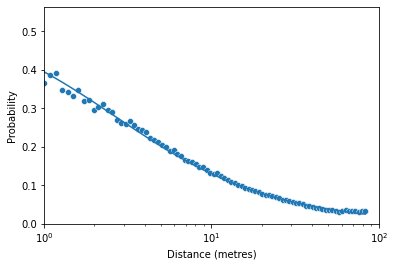

In [95]:
a= sns.scatterplot(np.exp(odds.index.categories.mid)-1,odds/(1+odds))
sns.lineplot(x='x',y='p',data=log_predicts,ax=a)
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1,100)
plt.ylabel('Probability')
plt.xlabel('Distance (metres)')
plt.savefig('../figures/distance_regression.png')


In [96]:
intersection_residuals_plot=collection.create_image(obs.x.round(0),obs.y.round(0),obs.i-m2.fittedvalues,1,bounds,mean=True)

In [97]:
pd.DataFrame(intersection_residuals_plot.flatten()).describe()

,0
count,17078.000000
mean,-0.000192
std,0.024649
min,-0.204855
25%,-0.014471
50%,-0.004831
75%,0.010853
max,0.162948


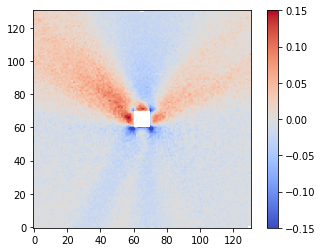

In [99]:
a=plt.imshow(intersection_residuals_plot,cmap='coolwarm',vmin=-0.15,vmax=0.15,origin='lower')
plt.colorbar(a)
plt.savefig('../figures/distance_residuals.png')

We also need to consider the effect of building height.


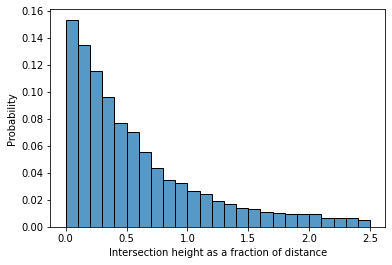

In [136]:
sns.histplot(np.tan(np.deg2rad(obs.el)),stat='probability',bins=25,binrange=(0,2.5))
plt.xlabel('Intersection height as a fraction of distance')
plt.savefig('../figures/elevation.png')

In [127]:
np.tan(np.deg2rad(obs.el))

0          0.200033
1          0.551315
2          0.105418
3          1.129408
4          0.324565
             ...   
9818696    0.521505
9818697    0.231781
9818698    0.036051
9818699    1.056946
9818700    1.177067
Name: el, Length: 9818701, dtype: float64

In [31]:
from metrics import _indicator as indicator

In [55]:
cuts_=pd.cut(obs.d_building,100)

In [70]:
indicators = []
for i,h in enumerate([5,10,20,40]):
    for j,m in enumerate([1,4,8,np.inf]):
        df=pd.DataFrame({'Height':h,'Metric':m, 'Distance': cuts_.cat.categories.mid, "Proportion": indicator(obs.z,h,m).astype('int').groupby(cuts_).mean()})
        indicators.append(df)
indicators=pd.concat([i.reset_index() for i in indicators])
indicators.Height=indicators.Height.astype('category')
indicators.Metric=indicators.Metric.astype('category')

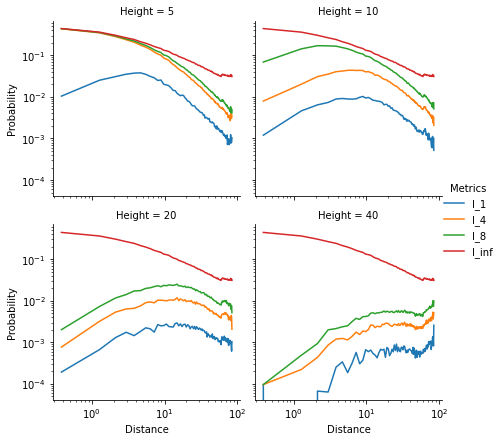

In [116]:
g=sns.FacetGrid(indicators,col='Height',col_wrap=2,sharex=True,sharey=True,legend_out=True)
g=g.map_dataframe(sns.lineplot,x='Distance',y='Proportion',hue='Metric').add_legend()
g._legend.set_title('Metrics')
new_labels = ['I_1', 'I_4','I_8', 'I_inf']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.xscale('log')
plt.yscale('log')
g.set_ylabels('Probability')
g.set_xlabels('Distance')
# plt.legend()
plt.savefig('../figures/height_metrics.png')

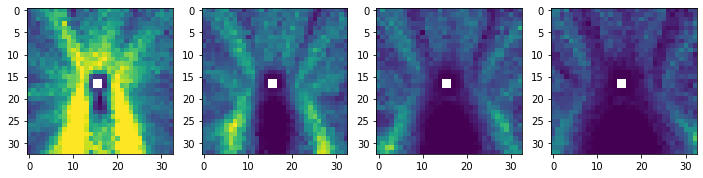

In [165]:
fig,axes=plt.subplots(ncols=4,figsize=(12,4))
for i,h in enumerate([10,20,30,40]):
    axes[i].imshow(collection.create_image(obs.x,obs.y,indicator(obs.z,h,4).astype('int'),0.25,bounds,mean=False)/(i_count+0.01),vmin=0,vmax=0.35)

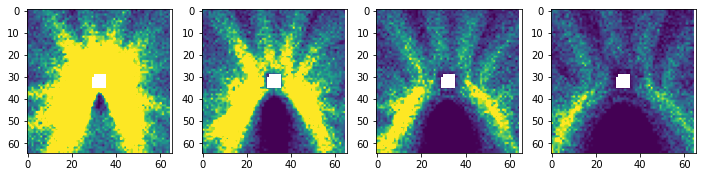

In [167]:
fig,axes=plt.subplots(ncols=4,figsize=(12,4))
for i,h in enumerate([10,20,30,40]):
    axes[i].imshow(collection.create_image(obs.x,obs.y,indicator(obs.z,h,4).astype('int'),0.5,bounds,mean=True),vmin=0,vmax=0.01)